***Predecting Temperatures in london***

As the climate changes, predicting the weather becomes ever more important for businesses. You have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `mlflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [2]:
# Import librerias
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

/Users/joserios/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [8]:
#Import data

weather = pd.read_csv('london_weather.csv')

exploratory data analysis and data cleaning

In [13]:
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1979,1
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1979,1
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1979,1
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1979,1
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1979,1


In [12]:
weather["date"] =  pd.to_datetime(weather["date"], format="%Y%m%d")
weather["year"] =  weather["date"].dt.year
weather["month"] = weather["date"].dt.month

In [18]:
# Aggregate and calculate average metrics
weather_metrics = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
weather_per_month = weather.groupby(['year', 'month'], as_index = False)[weather_metrics].mean()


/var/folders/_g/hjhxwzz574s2llr20k2xggsw0000gn/T/ipykernel_2898/3232588710.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)


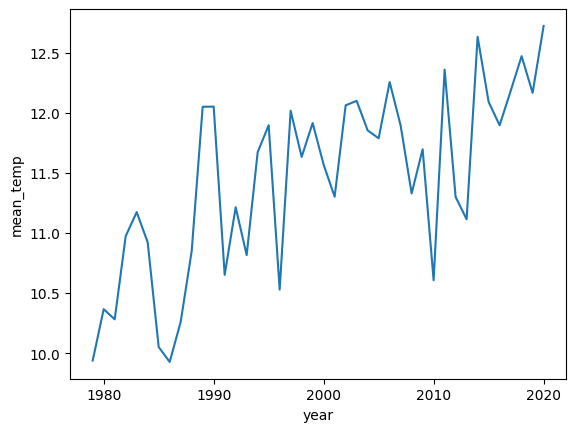

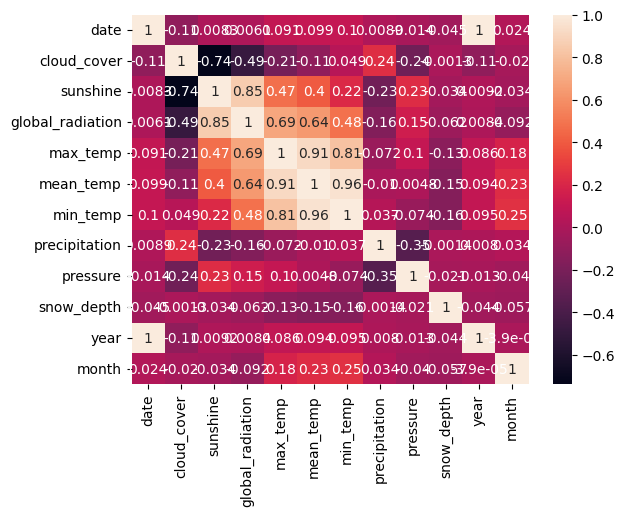

In [19]:
# Visualize relationships in the data
sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)
plt.show()
sns.heatmap(weather.corr(), annot=True)
plt.show()

In [21]:
# Choose features, define the target, and drop null values
feature_selection = ['month', 'cloud_cover', 'sunshine', 'precipitation', 'pressure', 'global_radiation']
target_var = 'mean_temp'
weather = weather.dropna(subset=['mean_temp'])

In [22]:

# Subset feature and target sets
X = weather[feature_selection]    
y = weather[target_var]
    
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    


In [23]:
# Impute missing values
imputer = SimpleImputer(strategy="mean")
# Fit on the training data
X_train = imputer.fit_transform(X_train)
# Transform on the test data
X_test  = imputer.transform(X_test)
    


In [24]:
# Scale the data
scaler = StandardScaler()
# Fit on the training data
X_train = scaler.fit_transform(X_train)
# Transform on the test data
X_test = scaler.transform(X_test)  

In [25]:
# Predict, evaluate, and log the parameters and metrics of your models
for idx, depth in enumerate([1, 2, 5, 10, 20]): 
    run_name = f"run_{idx}"
    with mlflow.start_run(run_name=run_name):
        # Create models
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
        # Evaluate performance
        y_pred_lin_reg = lin_reg.predict(X_test)
        lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared=False)
        y_pred_tree_reg = tree_reg.predict(X_test)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared=False)
        y_pred_forest_reg = forest_reg.predict(X_test)
        forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)
        
# Search the runs for the experiment's results
experiment_results = mlflow.search_runs()
experiment_results

2024/08/13 12:14:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/13 12:14:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/13 12:14:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
/Users/joserios/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/joserios/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squar

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_fr,metrics.rmse_tr,metrics.rmse_lr,params.max_depth,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.type
0,8e4d118ebb4f4896833ac6509e81e999,0,FINISHED,file:///Users/joserios/Documents/Proyectos/Lon...,2024-08-13 10:14:20.825000+00:00,2024-08-13 10:14:25.993000+00:00,2.891367,3.792623,3.866773,20,/Users/joserios/Library/Python/3.9/lib/python/...,joserios,run_4,"[{""run_id"": ""8e4d118ebb4f4896833ac6509e81e999""...",LOCAL
1,e838b082e265490e80a3af7e18a6bfff,0,FINISHED,file:///Users/joserios/Documents/Proyectos/Lon...,2024-08-13 10:14:16.487000+00:00,2024-08-13 10:14:20.822000+00:00,2.814683,3.068346,3.866773,10,/Users/joserios/Library/Python/3.9/lib/python/...,joserios,run_3,"[{""run_id"": ""e838b082e265490e80a3af7e18a6bfff""...",LOCAL
2,367c6332a5c54de1a87680ac97396e3e,0,FINISHED,file:///Users/joserios/Documents/Proyectos/Lon...,2024-08-13 10:14:12.735000+00:00,2024-08-13 10:14:16.485000+00:00,2.967462,3.027733,3.866773,5,/Users/joserios/Library/Python/3.9/lib/python/...,joserios,run_2,"[{""run_id"": ""367c6332a5c54de1a87680ac97396e3e""...",LOCAL
3,c0eb6aa0dfe440d2bdb9a29100d06c81,0,FINISHED,file:///Users/joserios/Documents/Proyectos/Lon...,2024-08-13 10:14:09.349000+00:00,2024-08-13 10:14:12.726000+00:00,3.832143,3.917318,3.866773,2,/Users/joserios/Library/Python/3.9/lib/python/...,joserios,run_1,"[{""run_id"": ""c0eb6aa0dfe440d2bdb9a29100d06c81""...",LOCAL
4,39f4499e1d2a43759002122872838374,0,FINISHED,file:///Users/joserios/Documents/Proyectos/Lon...,2024-08-13 10:14:04.741000+00:00,2024-08-13 10:14:09.347000+00:00,4.694655,4.752035,3.866773,1,/Users/joserios/Library/Python/3.9/lib/python/...,joserios,run_0,"[{""run_id"": ""39f4499e1d2a43759002122872838374""...",LOCAL


**Results Analysis**

Best Model (Based on Random Forest RMSE):
The run run_3 with max_depth=10 has the lowest metrics.rmse_fr (2.814683), indicating that this Random Forest model is the most accurate in its predictions.

Model Comparison:

-Linear Regression (metrics.rmse_lr): It has a constant RMSE of 3.866773 across all runs, suggesting its predictive performance is not affected by tree depth.

-Decision Tree (metrics.rmse_tr): RMSE decreases as tree depth increases, reaching its best value (3.068346) at max_depth=10, after which it seems to increase again.

-Random Forest (metrics.rmse_fr): It shows a similar trend to the Decision Tree, but generally with a lower RMSE, indicating overall better performance.


***Conclusion***

In my experiment, the Random Forest model with a maximum depth of 10 (run_3) appears to be the most suitable model, as it offers the lowest RMSE (2.814683). This suggests that this model strikes a good balance between fitting the data and maintaining strong generalization capabilities.

